In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
)
from xgboost import XGBRegressor
import xgboost as xgb
import matplotlib.pyplot as plt

In [18]:
df_final = pd.read_csv("../data/dfgeopoli.csv")
df_final.dropna(subset=['logallexports'], inplace=True)

In [19]:
df_final.columns

Index(['year', 'country_id_o', 'country_o', 'country_id_d', 'country_d',
       'contig', 'distcap', 'dist', 'comlang_off', 'comlang_ethno', 'comrelig',
       'pop_o', 'pop_d', 'gdp_o', 'gdp_d', 'gdpcap_o', 'gdpcap_d', 'fta_wto',
       'tradeflow_comtrade_o', 'tradeflow_comtrade_d', 'tradeflow_imf_o',
       'tradeflow_imf_d', 'IdealPointDistance', 'arms', 'tot_o', 'tot_d',
       'tgdp_ratio_o', 'tgdp_ratio_d', 'avgtradeflow', 'logtradeflow',
       'v2x_polyarchy_o', 'v2x_libdem_o', 'v2x_partipdem_o', 'v2x_delibdem_o',
       'v2x_egaldem_o', 'v2x_polyarchy_d', 'v2x_libdem_d', 'v2x_partipdem_d',
       'v2x_delibdem_d', 'v2x_egaldem_d', 'allexports', 'chemicalexports',
       'consumerexports', 'foodexports', 'machineryexports',
       'manufacturesexports', 'logallexports', 'logchemicalexports',
       'logconsumerexports', 'logfoodexports', 'logmachineryexports',
       'logmanufacturesexports', 'v2x_polyarchy_diff', 'v2x_libdem_diff',
       'v2x_partipdem_diff', 'v2x_delibdem_d

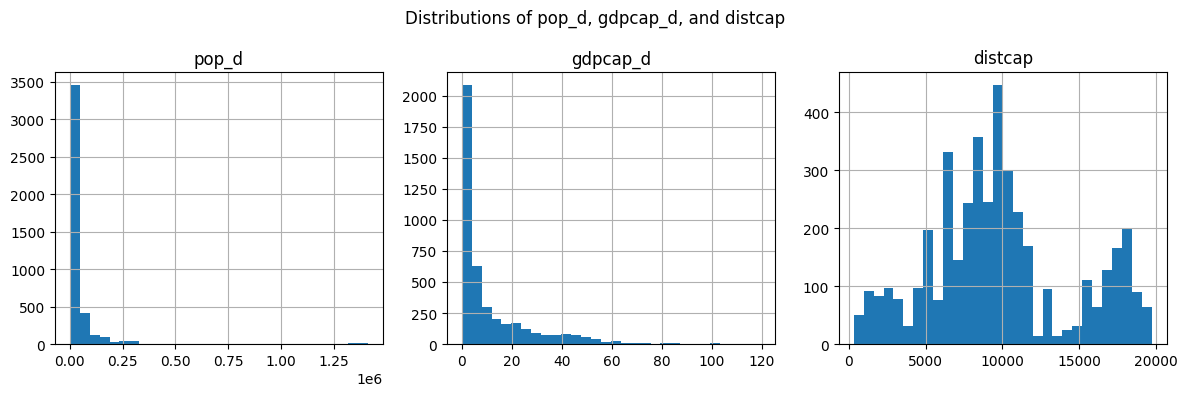

In [20]:
cols = ['pop_d', 'gdpcap_d', 'distcap']

df_final[cols].hist(bins=30, figsize=(12, 4), layout=(1, 3))
plt.suptitle("Distributions of pop_d, gdpcap_d, and distcap")
plt.tight_layout()
plt.show()

In [21]:
# Standardizing non-geopolitical measures

df_final['log_pop_d'] = np.log1p(df_final['pop_d'])
df_final['log_gdpcap_d'] = np.log1p(df_final['gdpcap_d'])
scaler = StandardScaler()
df_final[['log_pop_d', 'log_gdpcap_d', 'distcap']] = scaler.fit_transform(df_final[['log_pop_d', 'log_gdpcap_d', 'distcap']])

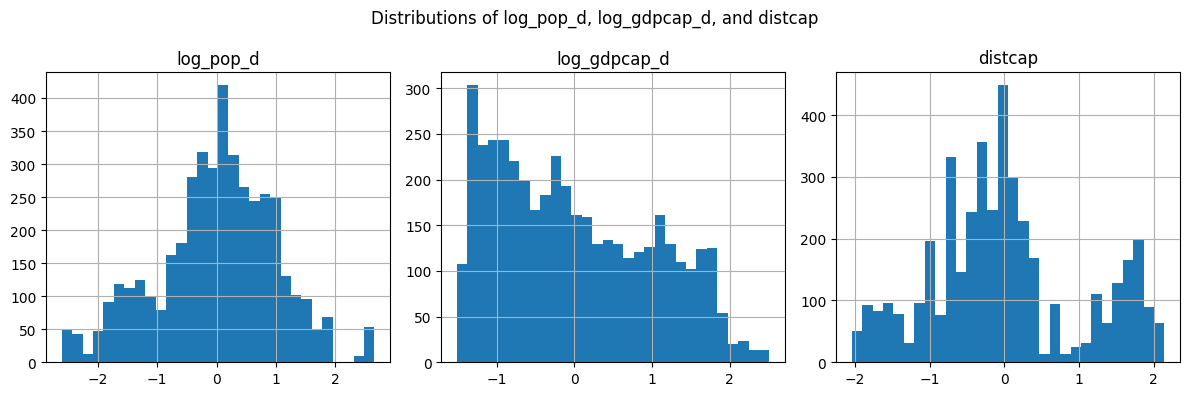

In [22]:
cols = ['log_pop_d', 'log_gdpcap_d', 'distcap']

df_final[cols].hist(bins=30, figsize=(12, 4), layout=(1, 3))
plt.suptitle("Distributions of log_pop_d, log_gdpcap_d, and distcap")
plt.tight_layout()
plt.show()

In [23]:
# Modeling
target = 'logallexports'
predictors = ['log_pop_d', 'log_gdpcap_d', 'distcap', 'geopolitical_closeness_index_fa']
X = df_final[predictors]
y = df_final[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=222
)

In [24]:
# Training
model = XGBRegressor(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=222
)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [25]:
# Model Evaluation
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"\nEvaluation for target: {target}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.4f}")


Evaluation for target: logallexports
RMSE: 1.0186
MAE: 0.7628
R²: 0.8625
MAPE: 0.0440


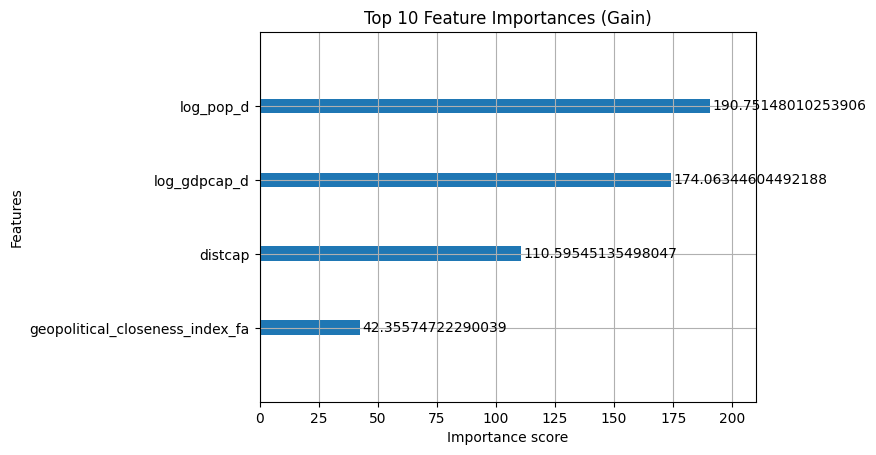

In [26]:
xgb.plot_importance(model, max_num_features=10, importance_type='gain')
plt.title("Top 10 Feature Importances (Gain)")
plt.show()

In [28]:
import shap
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

index_pos = list(X_test.columns).index('geopolitical_closeness_index_fa')
feat_pos = X_test['geopolitical_closeness_index_fa']
shap_pos = shap_values[:, index_pos]

corr_pos, p_val_pos = pearsonr(feat_pos, shap_pos)
print(f"Correlation for geopolitical_closeness_index_fa': {corr_pos:.4f} (p={p_val_pos:.4f})")

Correlation for geopolitical_closeness_index_fa': 0.7731 (p=0.0000)


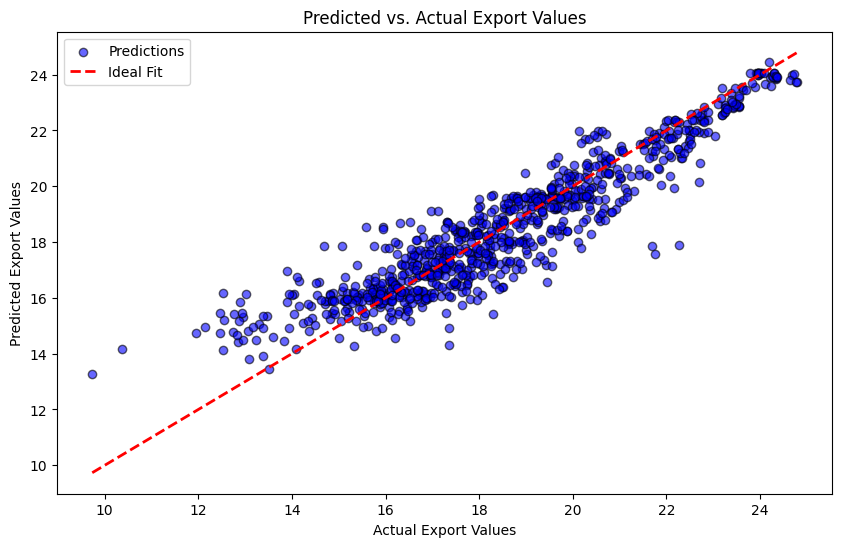

In [29]:
# Predict on the test set using your fitted model (XGBRegressor)
y_pred = model.predict(X_test)

# Create a scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6, edgecolor='k', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Ideal Fit')
plt.xlabel("Actual Export Values")
plt.ylabel("Predicted Export Values")
plt.title("Predicted vs. Actual Export Values")
plt.legend()
plt.show()

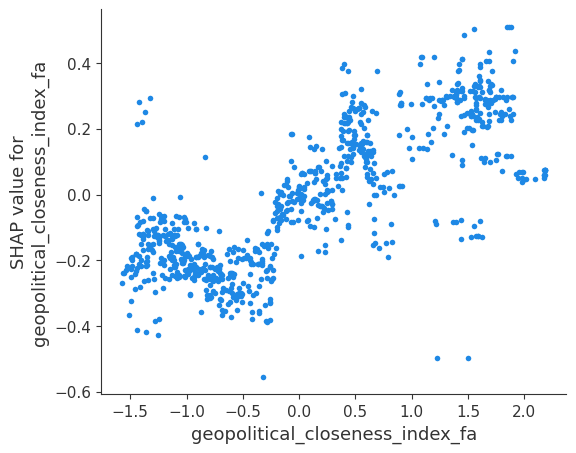

In [31]:
shap.dependence_plot('geopolitical_closeness_index_fa', shap_values, X_test, interaction_index=None)